In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
from tqdm import tqdm

import shutil
# util function
def create_or_clear_folder(folder_path):
    # Check whether the folder exists
    if os.path.exists(folder_path):
        # If the folder exists, delete it and recreate it
        shutil.rmtree(folder_path)
        os.makedirs(folder_path)
    else:
        # If the folder does not exist, create it
        os.makedirs(folder_path)

In [3]:
data_folder = "/content/drive/MyDrive/ACDS/Selected_Storms_curated"


# Dataset
Use two-dimensional lists to store image information

In [4]:
# load data

samples = []

subfolder = os.listdir(data_folder)
print(subfolder)
for fol in subfolder:
    print(fol)
    now_sample = []
    wind_folder = os.path.join(data_folder, fol)
    useful_data = list(set([f[:7] for f in os.listdir(wind_folder) if f.startswith(fol)]))
    for name in useful_data:
        image_path = os.path.join(wind_folder, name+'.jpg')
        json_path = os.path.join(wind_folder, name+'_features.json')
        time = eval(json.load(open(json_path,'r'))['relative_time'])
        now_sample.append((image_path, time))
    now_sample.sort(key=lambda x: x[1])
    samples.append(now_sample)

['hig', 'gme', 'woc', 'blq', 'kqu', 'wsy', 'ipa', 'ztb', 'gkf', 'qpq', 'pjj', 'rml', 'xjo', 'vxf', 'fgi', 'gic', 'fna', 'ing', 'yfn', 'ywf', 'mtw', 'eoi', 'sxb', 'vye', 'zny', 'psz', 'pvj', 'dzw', 'ojv', 'bkh']
hig
gme
woc
blq
kqu
wsy
ipa
ztb
gkf
qpq
pjj
rml
xjo
vxf
fgi
gic
fna
ing
yfn
ywf
mtw
eoi
sxb
vye
zny
psz
pvj
dzw
ojv
bkh


In [5]:
len(samples)

30

# Time Embedding
After EDA analysis, it was noticed that the sample number and the standard deviation and precision difference of the time interval between different types of storms were different, so the means of time coding was adopted here (considering the time limit of the overall development process, a relatively simple way was chosen).


The code processes image sequences with the following steps:

1. **Image Sequence Extraction**: Sequentially selects images from a specified index to form a complete sequence, including historical images and future images for prediction. The length of the historical image sequence is defined by `self.sequence_length`, and the length of the future image sequence for prediction is defined by `self.pre_len`.
2. **Image Loading**: Loads images from a pre-processed list of image data to avoid repetitive disk reads, enhancing efficiency.
3. **Time ID Calculation**: Calculates a time ID for each image, indicating the time difference from the first image in the sequence, to capture the temporal dimension.
4. **Sequence Division**: Divides the complete image sequence into two parts: a sequence of historical images for model input and a sequence of future images for prediction.

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((366, 366)),
    transforms.ToTensor(),

    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #
])

class ImageSequenceDataset(Dataset):
    def __init__(self, data, sequence_length=6, pre_len=3, transform=None) -> None:
        super().__init__()
        self.data = data
        self.sequence_length = sequence_length
        self.pre_len = pre_len
        self.transform = transform

        self.data_id = []
        for i, d in enumerate(self.data):
            for j in range(len(d)-sequence_length-pre_len+1):
                self.data_id.append((i, j))

        self.img_data = []
        for wd in tqdm(self.data, desc='Processing Data'):
            now_img = []
            for image_path, time in wd:
                image = Image.open(image_path).convert('L')

                if self.transform:
                    image = self.transform(image)
                now_img.append(image)
            self.img_data.append(now_img)

    def __len__(self):
        return len(self.data_id)

    def __getitem__(self, idx):
        wind_id, sample_id = self.data_id[idx]
        time_start = self.data[wind_id][sample_id][1] #Start time time ➗1000 is the time embedding id

        images = []
        times = []

        for i in range(sample_id, sample_id+self.sequence_length+self.pre_len):
            image_path, time = self.data[wind_id][i]

            image = self.img_data[wind_id][i]
            images.append(image)
            time_id = (time-time_start)//1000
            if time_id > 49:time_id = 49
            elif time_id <0:time_id = 0


            times.append(time_id)
            time_start = time

        sequence_images = images[:self.sequence_length]
        prediction_images = images[self.sequence_length:]

        sequence_images = torch.stack(sequence_images)
        prediction_images = torch.stack(prediction_images)
        times = torch.LongTensor(times)

        return sequence_images, prediction_images, times

Add for some tests

This means using GME to simulate an unknown storm forecast. Measure our model by setting GME as a test set and seeing how the model performs on it

In [13]:
# print(f"Test wind - {subfolder[-1]}")
# train_dataset = ImageSequenceDataset(samples[:-1], transform=transform)
# test_dataset = ImageSequenceDataset(samples[-1:], transform=transform)

# train_dataloader = DataLoader(train_dataset,
#                         batch_size=8,
#                         shuffle=True)

# test_dataloader = DataLoader(train_dataset,
#                         batch_size=8,
#                         shuffle=False)

Test wind - bkh


Processing Data: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


In [7]:
train_samples = [sample for i, sample in enumerate(samples) if i != 1]  # no 'gme'
test_samples = [samples[1]]  # only gme

In [8]:
test_samples

[[('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_000.jpg', 0),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_001.jpg',
   1800),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_002.jpg',
   3600),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_003.jpg',
   5400),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_004.jpg',
   7200),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_005.jpg',
   10801),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_006.jpg',
   12602),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_007.jpg',
   14401),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_008.jpg',
   16201),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_009.jpg',
   18002),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_010.jpg',
   21601),
  ('/content/drive/MyDrive/ACDS/Selected_Storms_curated/gme/gme_011.jpg',
  

set bs = 8

In [9]:
print(f"Test wind - {subfolder[1]}")
train_dataset = ImageSequenceDataset(train_samples, transform=transform)
test_dataset = ImageSequenceDataset(test_samples, transform=transform)

train_dataloader = DataLoader(train_dataset,
                        batch_size=8,
                        shuffle=True)

test_dataloader = DataLoader(test_dataset,
                        batch_size=8,
                        shuffle=False)

Test wind - gme


Processing Data: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


In [10]:

last_batch_data = None

# Itering test_dataLoader
for batch_data in test_dataloader:
    last_batch_data = batch_data  # Update the data for the last batch

if last_batch_data is not None:
    sequence_images, prediction_images, times = last_batch_data
    print(f"Sequence images shape: {sequence_images.shape}")
    print(f"Prediction images shape: {prediction_images.shape}")
    print(f"Times shape: {times.shape}")
else:
    print("No data in the DataLoader")


Sequence images shape: torch.Size([1, 6, 1, 366, 366])
Prediction images shape: torch.Size([1, 3, 1, 366, 366])
Times shape: torch.Size([1, 9])


- `sequence_images`: A tensor of sequence images with the shape `[batch_size, sequence_length, channels, height, width]`.
- `prediction_images`: A tensor of prediction images with the shape `[batch_size, pre_len, channels, height, width]`, where `pre_len` is the number of images to be predicted.
- `times`: Timestamp information with the shape `[batch_size, sequence_length + pre_len]`.

# Model
Let's move on to the definition of the model: this is based on a very standard ConvLSTM schema change, with some differences from our group's second implementation, CNN_LSTM, which is a more integrated approach that deals with both spatial and temporal information at each time step. CNN_LSTM is a two-stage approach, processing spatial information first, and then processing time information.

In [11]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size // 2, kernel_size // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim=1, hidden_dim=[16, 8, 1], kernel_size=[3,3,3], num_layers=3,
                 batch_first=True, bias=True, return_all_layers=True):
        super(ConvLSTM, self).__init__()

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        # Add and initialize parameters
        self.time_embedding = nn.Parameter(torch.zeros(50, 1, 366, 366), requires_grad=True)

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, times, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor + self.time_embedding[times[:,:input_tensor.size(1)]]

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
model = ConvLSTM()
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [16]:
model

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(17, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(9, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

10 epochs with batch_size = 8:

In [13]:
best_epoch_loss = float('inf')
all_loss = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}") as tepoch:
        for i, (input_sequences, target_sequences, times) in tepoch:

            input_sequences = input_sequences.to(device)
            target_sequences = target_sequences.to(device)
            times = times.to(device)

            optimizer.zero_grad()

            # Forward propagation
            layer_output_list, _ = model(input_sequences, times)
            output_sequences = layer_output_list[-1][:,-target_sequences.size(1):]  # Take the output of the last layer

            # calculate loss
            loss = criterion(output_sequences, target_sequences)
            epoch_loss += loss.item()
            all_loss.append(loss.item())
            # Backpropagation and Optimization
            loss.backward()
            optimizer.step()

            # Update progress bar
            tepoch.set_postfix(loss=epoch_loss/(i+1))

    average_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Average Loss for Epoch {epoch + 1}: {average_epoch_loss:.4f}")

    # Check if it is the best model
    if average_epoch_loss < best_epoch_loss:
        best_epoch_loss = average_epoch_loss
        # save_model
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/10: 100%|██████████| 1136/1136 [14:08<00:00,  1.34it/s, loss=0.0186]


Average Loss for Epoch 1: 0.0186


Epoch 2/10: 100%|██████████| 1136/1136 [12:33<00:00,  1.51it/s, loss=0.0138]


Average Loss for Epoch 2: 0.0138


Epoch 3/10: 100%|██████████| 1136/1136 [12:33<00:00,  1.51it/s, loss=0.0137]


Average Loss for Epoch 3: 0.0137


Epoch 4/10: 100%|██████████| 1136/1136 [12:33<00:00,  1.51it/s, loss=0.0135]


Average Loss for Epoch 4: 0.0135


Epoch 5/10: 100%|██████████| 1136/1136 [12:33<00:00,  1.51it/s, loss=0.0132]


Average Loss for Epoch 5: 0.0132


Epoch 6/10: 100%|██████████| 1136/1136 [12:33<00:00,  1.51it/s, loss=0.013]


Average Loss for Epoch 6: 0.0130


Epoch 7/10: 100%|██████████| 1136/1136 [12:33<00:00,  1.51it/s, loss=0.0129]


Average Loss for Epoch 7: 0.0129


Epoch 8/10: 100%|██████████| 1136/1136 [12:33<00:00,  1.51it/s, loss=0.0129]


Average Loss for Epoch 8: 0.0129


Epoch 9/10: 100%|██████████| 1136/1136 [12:33<00:00,  1.51it/s, loss=0.0128]


Average Loss for Epoch 9: 0.0128


Epoch 10/10: 100%|██████████| 1136/1136 [12:33<00:00,  1.51it/s, loss=0.0128]


Average Loss for Epoch 10: 0.0128


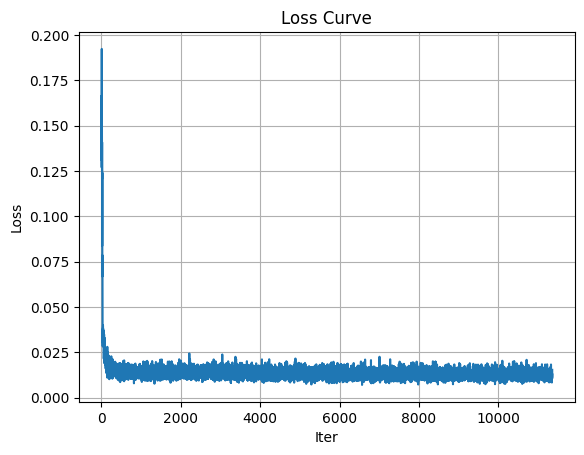

In [14]:
import matplotlib.pyplot as plt

plt.plot(all_loss)
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.grid("--")
plt.savefig("loss_curve.png", dpi=300)

In [15]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

When iterating through the test data loader (`test_dataloader`), the model generates predictions for each batch. If we set `'gme'` as the test set, the comparison between the model's predictions and the actual situation of each image depends on the following aspects:

- **Batch Size**: `batch_size` determines the number of images processed by the model at each pass. If `batch_size` is set to 8, then 8 images will be processed simultaneously by the model in each iteration.

- **Batch Processing**: For each batch, the model makes predictions for all the images within it, generating an output sequence. Subsequently, the code will draw input, target (real), predicted, and difference images for each image in that batch.

- **Per-Image Processing**: Within each batch, the code processes each image individually through a loop (`for k in range(len(input_sequences)):`), generating and saving corresponding images for each.

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
all_inputs = []
all_labels = []
all_preds = []

create_or_clear_folder(os.path.join("TestImage"))

model.eval()
with tqdm(enumerate(test_dataloader), total=len(test_dataloader)) as tepoch:
    for j, (input_sequences, target_sequences, times) in tepoch:

        input_sequences = input_sequences.to(device)
        target_sequences = target_sequences.to(device)
        times = times.to(device)

        #
        layer_output_list, _ = model(input_sequences, times)
        output_sequences = layer_output_list[-1][:,-target_sequences.size(1):]  # Take the output of the last layer

        for k in range(len(input_sequences)):
            for i, img in enumerate(input_sequences[k].detach().cpu()):
                img = img.clamp(0, 1)
                img = TF.to_pil_image(img)
                plt.subplot(3, 6, i+1)
                plt.imshow(img, cmap='gray')
                plt.axis('off')  # Do not display coordinate axes
                plt.title(f'Input-{i+1}')

            for i, img in enumerate(target_sequences[k].detach().cpu()):
                img = img.clamp(0, 1)
                img = TF.to_pil_image(img)
                plt.subplot(3, 6, i+1+6)
                plt.imshow(img, cmap='gray')
                plt.axis('off')  # Do not display coordinate axes
                plt.title(f'Target-{i+1}')

            for i, img in enumerate(output_sequences[k].detach().cpu()):
                img = img.clamp(0, 1)
                img = TF.to_pil_image(img)
                plt.subplot(3, 6, i+1+6+3)
                plt.imshow(img, cmap='gray')
                plt.axis('off')  # Do not display coordinate axes
                plt.title(f'Prediction-{i+1}')
            # Draw the difference between the target image and the predicted image
            for i, (target_img, output_img) in enumerate(zip(target_sequences[k], output_sequences[k])):
                # Calculated difference
                diff = torch.abs(target_img - output_img)
                diff = diff.clamp(0, 1)  # Make sure the difference is within a valid range
                diff = TF.to_pil_image(diff)
                # Draw a difference image
                plt.subplot(3, 6, i+1+12)  # Adjust the position of the subgraph
                plt.imshow(diff, cmap='gray')
                plt.axis('off')
                plt.title(f'Difference-{i+1}')

            # Adjust the spacing of subgraphs
            plt.tight_layout()

            # Save or display the image
            plt.savefig(os.path.join("TestImage", f"Sample-{k}-{j}.jpg"))  # Save image

 92%|█████████▏| 24/26 [54:06<07:50, 235.15s/it]

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize cumulative difference and image count
total_diff = 0
total_images = 0

model.eval()
with tqdm(enumerate(test_dataloader), total=len(test_dataloader)) as tepoch:
    for j, (input_sequences, target_sequences, times) in tepoch:
        input_sequences = input_sequences.to(device)
        target_sequences = target_sequences.to(device)
        times = times.to(device)

        # Forward pass
        layer_output_list, _ = model(input_sequences, times)
        output_sequences = layer_output_list[-1][:, -target_sequences.size(1):]  # Take the output of the last layer

        for k in range(len(input_sequences)):
            # (Code for generating and saving images)

            # Calculate absolute difference and update total difference and image count
            diff = torch.abs(target_sequences[k] - output_sequences[k])
            total_diff += diff.sum().item()  # Update total difference
            total_images += diff.numel()  # Update total number of pixels across all images

# Calculate and print Mean Absolute Error (MAE) over all test images
mae = total_diff / total_images
print(f'Mean Absolute Error (MAE) over all test images: {mae:.4f}')


In [ ]:
# Save the prediction pictures
import torchvision.transforms.functional as TF

subfolder = os.listdir(data_folder)
create_or_clear_folder("Result")
for fol in subfolder:
    now_sample = []
    wind_folder = os.path.join(data_folder, fol)
    useful_data = list(set([f[:7] for f in os.listdir(wind_folder) if f.startswith(fol)]))
    for name in useful_data:
        image_path = os.path.join(wind_folder, name+'.jpg')
        json_path = os.path.join(wind_folder, name+'_features.json')
        time = eval(json.load(open(json_path,'r'))['relative_time'])
        now_sample.append((image_path, time))
    now_sample.sort(key=lambda x: x[1])

    inp_image = []
    inp_time = []
    time_start = now_sample[-6][1]
    for imgpath, time in now_sample[-6:]:
        image = Image.open(imgpath).convert('L')
        image = transform(image)
        inp_image.append(image)

        time_id = (time-time_start)//1000
        if time_id > 49:time_id = 49
        elif time_id <0:time_id = 0
        inp_time.append(time_id)
        time_start = time
    sequence_images = torch.stack(inp_image).to(device).unsqueeze(0)
    times = torch.LongTensor(inp_time).to(device).unsqueeze(0)
    layer_output_list, _ = model(sequence_images, times)
    output_sequences = layer_output_list[-1][0,-3:].detach().cpu()  # 取最后一层的输出
    create_or_clear_folder(os.path.join("Result", fol))
    for i, img in enumerate(output_sequences):
        img = img.clamp(0, 1)

        #
        img = TF.to_pil_image(img)
        # save images
        img.save(os.path.join("Result", fol, "{}.jpg".format(i+1)))

The memory usage of the colab session crashed, and the fault was rectified later

# Save Zip File to local machine

In [1]:
shutil.make_archive("Test_whole_GME", 'zip', "/content/TestImage")

NameError: name 'shutil' is not defined

In [ ]:
from google.colab import files

files.download("Test_whole_GME.zip")


# Version2
Add layers

In [ ]:

class ConvLSTM_2(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(
        self,
        input_dim=1,
        hidden_dim=[16, 8, 8, 1],
        kernel_size=[5, 3, 3, 3],
        num_layers=4,
        batch_first=True,
        bias=True,
        return_all_layers=True,
    ):
        super(ConvLSTM_2, self).__init__()

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError("Inconsistent list length.")

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        # Add and initialize parameters
        self.time_embedding = nn.Parameter(
            torch.zeros(50, 1, 366, 366), requires_grad=True
        )

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(
                ConvLSTMCell(
                    input_dim=cur_input_dim,
                    hidden_dim=self.hidden_dim[i],
                    kernel_size=self.kernel_size[i],
                    bias=self.bias,
                )
            )

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, times, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = (
            input_tensor + self.time_embedding[times[:, : input_tensor.size(1)]]
        )

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](
                    input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c]
                )
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

In [ ]:
num_epochs = 10
model = ConvLSTM_2()
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
model

ConvLSTM_2(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(17, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ConvLSTMCell(
      (conv): Conv2d(9, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [ ]:
best_epoch_loss = float("inf")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    with tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Epoch {epoch + 1}/{num_epochs}",
    ) as tepoch:
        for i, (input_sequences, target_sequences, times) in tepoch:
            input_sequences = input_sequences.to(device)
            target_sequences = target_sequences.to(device)
            times = times.to(device)

            optimizer.zero_grad()

            # Forward
            layer_output_list, _ = model(input_sequences, times)
            output_sequences = layer_output_list[-1][
                :, -target_sequences.size(1) :
            ]  # Get the output of the last layer

            # calculate loss
            loss = criterion(output_sequences, target_sequences)
            epoch_loss += loss.item()

            # backward and optimizer
            loss.backward()
            optimizer.step()

            # Update the progress bar
            tepoch.set_postfix(loss=epoch_loss / (i + 1))

    average_epoch_loss = epoch_loss / len(dataloader)
    print(f"Average Loss for Epoch {epoch + 1}: {average_epoch_loss:.4f}")

    # Check if it is the best model
    if average_epoch_loss < best_epoch_loss:
        best_epoch_loss = average_epoch_loss
        # save model
        torch.save(model.state_dict(), "add_layer_model.pth")

Epoch 1/10: 100%|██████████| 1161/1161 [20:45<00:00,  1.07s/it, loss=0.0168]


Average Loss for Epoch 1: 0.0168


Epoch 2/10: 100%|██████████| 1161/1161 [19:45<00:00,  1.02s/it, loss=0.0132]


Average Loss for Epoch 2: 0.0132


Epoch 3/10: 100%|██████████| 1161/1161 [19:46<00:00,  1.02s/it, loss=0.0128]


Average Loss for Epoch 3: 0.0128


Epoch 4/10: 100%|██████████| 1161/1161 [19:46<00:00,  1.02s/it, loss=0.0124]


Average Loss for Epoch 4: 0.0124


Epoch 5/10: 100%|██████████| 1161/1161 [19:46<00:00,  1.02s/it, loss=0.0122]


Average Loss for Epoch 5: 0.0122


Epoch 6/10: 100%|██████████| 1161/1161 [19:46<00:00,  1.02s/it, loss=0.0121]


Average Loss for Epoch 6: 0.0121


Epoch 7/10: 100%|██████████| 1161/1161 [19:45<00:00,  1.02s/it, loss=0.012]


Average Loss for Epoch 7: 0.0120


Epoch 8/10: 100%|██████████| 1161/1161 [19:45<00:00,  1.02s/it, loss=0.0119]


Average Loss for Epoch 8: 0.0119


Epoch 9/10: 100%|██████████| 1161/1161 [19:46<00:00,  1.02s/it, loss=0.0118]


Average Loss for Epoch 9: 0.0118


Epoch 10/10: 100%|██████████| 1161/1161 [19:46<00:00,  1.02s/it, loss=0.0118]


Average Loss for Epoch 10: 0.0118


In [ ]:
# save predicted images

subfolder = os.listdir(data_folder)
create_or_clear_folder("Result2")
for fol in subfolder:
    now_sample = []
    wind_folder = os.path.join(data_folder, fol)
    useful_data = list(
        set([f[:7] for f in os.listdir(wind_folder) if f.startswith(fol)])
    )
    for name in useful_data:
        image_path = os.path.join(wind_folder, name + ".jpg")
        json_path = os.path.join(wind_folder, name + "_features.json")
        time = eval(json.load(open(json_path, "r"))["relative_time"])
        now_sample.append((image_path, time))
    now_sample.sort(key=lambda x: x[1])

    inp_image = []
    inp_time = []
    time_start = now_sample[-6][1]
    for imgpath, time in now_sample[-6:]:
        image = Image.open(imgpath).convert("L")
        image = transform(image)
        inp_image.append(image)

        time_id = (time - time_start) // 1000
        if time_id > 49:
            time_id = 49
        elif time_id < 0:
            time_id = 0
        inp_time.append(time_id)
        time_start = time
    sequence_images = torch.stack(inp_image).to(device).unsqueeze(0)
    times = torch.LongTensor(inp_time).to(device).unsqueeze(0)
    layer_output_list, _ = model(sequence_images, times)
    output_sequences = layer_output_list[-1][0, -3:].detach().cpu()  # The output of the last layer
    create_or_clear_folder(os.path.join("Result2", fol))
    for i, img in enumerate(output_sequences):
        img = img.clamp(0, 1)

        # Convert Tensor to PIL image
        img = TF.to_pil_image(img)
        #
        img.save(os.path.join("Result2", fol, "{}.jpg".format(i + 1)))

# Someting need to do


1.   To adjust hyperparameters, try changing lr,bs,epoch....
2.   Tweaking code structure design -pipeline

